In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('eclipse_jdt.csv')
df=df[['Title','Description','Priority']]
df=df.dropna()
df['text']= df['Title']+''+df['Description']
df=df.drop(columns=['Title','Description'])

In [3]:
import textacy
import textacy.preprocessing as tprep

preproc = tprep.make_pipeline(
    tprep.replace.urls,
    tprep.remove.html_tags,
    tprep.normalize.hyphenated_words,
    tprep.normalize.quotation_marks,
    tprep.normalize.unicode,
    tprep.remove.accents,
    tprep.remove.punctuation,
    tprep.normalize.whitespace,
    tprep.replace.numbers
)

In [4]:
df['text']=df['text'].apply(preproc)
df=df[df['text'].str.len()>50]

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],df['Priority'], test_size=0.2,random_state=42,stratify=df['Priority'])

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect=CountVectorizer(min_df=10,ngram_range=(1,2),stop_words='english')
X_train_counts=count_vect.fit_transform(X_train)
X_test_counts=count_vect.transform(X_test)

In [7]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfV= TfidfTransformer(use_idf=True)
X_train_tfidf=tfidfV.fit_transform(X_train_counts)
X_test_tfidf=tfidfV.transform(X_test_counts)

### SVC Models

In [9]:
from sklearn.svm import LinearSVC
model1 = LinearSVC(random_state=0,tol=1e-5)
model1.fit(X_train_tfidf,Y_train)

LinearSVC(random_state=0, tol=1e-05)

In [10]:
X_test_counts=count_vect.transform(X_test)
X_test_tfidf=tfidfV.transform(X_test_counts)

In [11]:
Y_pred=model1.predict(X_test_tfidf)

In [12]:
from sklearn.metrics import accuracy_score
print('Accuracy score', accuracy_score(Y_test, Y_pred))

Accuracy score 0.8757908757908758


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,Y_pred,zero_division=0.0))

In [ ]:
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(Y_test,Y_pred,zero_division='warn'))

## Pipeline : CountVectorizer+TfidfVectorizer+LinearSVC

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

clf_text = Pipeline([
    ('vect', CountVectorizer(min_df=10,ngram_range=(1,2),stop_words='english')),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('svc',LinearSVC(random_state=0,tol=1e-5,dual='auto'))
])
clf_text.named_steps

In [ ]:
clf_text.fit(X_train,Y_train)

In [ ]:
Y_pred=clf_text.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy score', accuracy_score(Y_test, Y_pred))

In [ ]:
clf_text.fit(X_train,Y_train).score(Y_test,Y_pred)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

clf_text = Pipeline([
    ('tfidf', TfidfVectorizer(use_idf=True,min_df=5,ngram_range=(1,2),stop_words='english')),
    ('svc',LinearSVC(random_state=0,tol=1e-5,dual='auto'))
])
clf_text

In [ ]:
clf_text.fit(X_train,Y_train)
Y_pred=clf_text.predict(X_test)
from sklearn.metrics import accuracy_score
print('Accuracy score', accuracy_score(Y_test, Y_pred))


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,Y_pred,zero_division=0.0))

In [ ]:
clf_text.fit(X_train,Y_train).score(Y_test,Y_pred)

### XGBoost

In [8]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [9]:
Encoder = LabelEncoder()
Y_train_L = Encoder.fit_transform(Y_train)
Y_test_L = Encoder.fit_transform(Y_test)

In [10]:
clfxgb = XGBClassifier(random_state=42, seed=2)#, colsample_bytree=0.6, subsample=0.7

In [11]:
clfxgb.fit(X_train_tfidf,Y_train_L)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [12]:
Y_pred=clfxgb.predict(X_test_tfidf)

In [13]:
from sklearn.metrics import accuracy_score
print('Accuracy score', accuracy_score(Y_test_L, Y_pred))

Accuracy score 0.8774558774558775


In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm=confusion_matrix(Y_test_L,Y_pred)
print(cm)

[[  12    0  209    3    0]
 [   3    2  595    8    0]
 [  14    6 7854   24    1]
 [   0    0  191   37    0]
 [   0    0   50    0    0]]


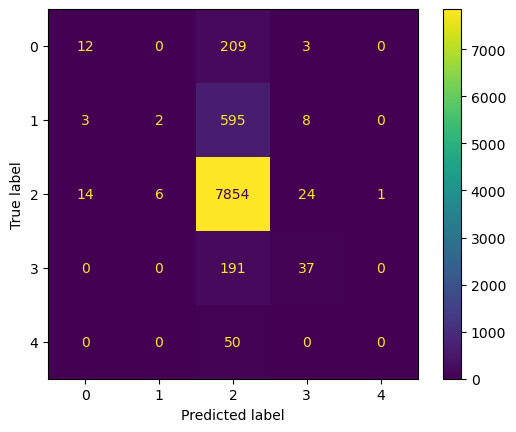

In [15]:
ConfusionMatrixDisplay.from_predictions(Y_test_L,Y_pred)
plt.show()

In [16]:
from imblearn.metrics import classification_report_imbalanced
target_names =['P1','P2','P3','P4','P5']
print(classification_report_imbalanced(Y_test_L,Y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.41      0.05      1.00      0.09      0.23      0.05       224
          1       0.25      0.00      1.00      0.01      0.06      0.00       608
          2       0.88      0.99      0.06      0.94      0.24      0.06      7899
          3       0.51      0.16      1.00      0.25      0.40      0.15       228
          4       0.00      0.00      1.00      0.00      0.00      0.00        50

avg / total       0.81      0.88      0.17      0.83      0.23      0.06      9009



### XGboost with resampling SMOTE

In [17]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [18]:
X_resamp, Y_resamp = SMOTE().fit_resample(X_train_tfidf,Y_train_L)

In [19]:
clfxgb.fit(X_resamp,Y_resamp)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [20]:
Y_pred=clfxgb.predict(X_test_tfidf)

In [21]:
from sklearn.metrics import accuracy_score
print('Accuracy score', accuracy_score(Y_test_L, Y_pred))

Accuracy score 0.8286158286158286


In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm=confusion_matrix(Y_test_L,Y_pred)
print(cm)

[[  51   18  149    6    0]
 [  32   42  512   21    1]
 [ 118  347 7296  118   20]
 [   2    8  140   75    3]
 [   0    1   46    2    1]]


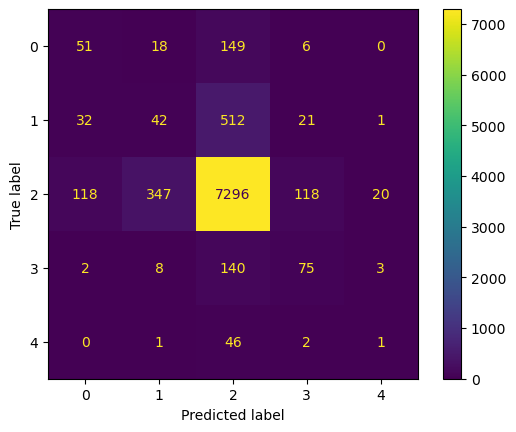

In [23]:
ConfusionMatrixDisplay.from_predictions(Y_test_L,Y_pred)
plt.show()

In [24]:
from imblearn.metrics import classification_report_imbalanced
target_names =['P1','P2','P3','P4','P5']
print(classification_report_imbalanced(Y_test_L,Y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.25      0.23      0.98      0.24      0.47      0.21       224
          1       0.10      0.07      0.96      0.08      0.26      0.06       608
          2       0.90      0.92      0.24      0.91      0.47      0.23      7899
          3       0.34      0.33      0.98      0.33      0.57      0.30       228
          4       0.04      0.02      1.00      0.03      0.14      0.02        50

avg / total       0.81      0.83      0.33      0.82      0.45      0.22      9009



### Next step : fine tuning of XGboost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}

# Create the XGBoost model object
xgb_model = xgb.XGBClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_tfidf, Y_train_L)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)